In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/UrbanSound8K'
audio_path = f'{data_path}/audio'
metadata_path = f'{data_path}/metadata/UrbanSound8K.csv'

# Metadata dosyasını yükle
metadata = pd.read_csv(metadata_path)
print(metadata.head())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [6]:
def create_spectrogram(file_path, output_size=(128, 128), n_mels=128, hop_length=512):
    try:
        y, sr = librosa.load(file_path, sr=None)
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, fmax=sr/2)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        if spectrogram_db.shape[1] > output_size[1]:
            spectrogram_db = spectrogram_db[:, :output_size[1]]
        else:
            padding = output_size[1] - spectrogram_db.shape[1]
            spectrogram_db = np.pad(spectrogram_db, ((0, 0), (0, padding)), mode='constant')
        return spectrogram_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [7]:
def augment_audio(y, sr):
    noise = np.random.normal(0, 0.05, y.shape)
    y_noise = y + noise

    # Hız değiştirme
    if len(y.shape) > 1:  # Stereo sinyali mono yap
        y = librosa.to_mono(y)

    y_fast = librosa.effects.time_stretch(y, rate=1.2)
    y_slow = librosa.effects.time_stretch(y, rate=0.8)

    # Pitch değiştirme
    y_pitch_up = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=4)  # 4 yarım ton artırma
    y_pitch_down = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=-4)  # 4 yarım ton düşürme

    return [y_noise, y_fast, y_slow, y_pitch_up, y_pitch_down]


def create_augmented_spectrograms(file_path, output_size=(128, 128)):
    y, sr = librosa.load(file_path, sr=None)
    augmented_audios = augment_audio(y, sr)
    spectrograms = []

    for audio in [y] + augmented_audios:
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=output_size[0], fmax=sr/2)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        if spectrogram_db.shape[1] > output_size[1]:
            spectrogram_db = spectrogram_db[:, :output_size[1]]
        else:
            padding = output_size[1] - spectrogram_db.shape[1]
            spectrogram_db = np.pad(spectrogram_db, ((0, 0), (0, padding)), mode='constant')
        spectrograms.append(spectrogram_db)

    return spectrograms

def visualize_spectrogram(spectrogram, title="Spectrogram"):
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', sr=22050, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


In [8]:
features = []
labels = []
selected_folds = [1, 2, 3]

for index, row in tqdm(metadata.iterrows(), total=len(metadata)):
    if row['fold'] in selected_folds:
        file_path = f"{audio_path}/fold{row['fold']}/{row['slice_file_name']}"
        augmented_spectrograms = create_augmented_spectrograms(file_path)
        if augmented_spectrograms:
            features.extend(augmented_spectrograms)
            labels.extend([row['classID']] * len(augmented_spectrograms))

features = np.array(features)
labels = np.array(labels)
features = features[..., np.newaxis]  # Kanal boyutu ekle


 95%|█████████▌| 8326/8732 [55:41<01:01,  6.57it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1838
  warnings.warn(
100%|██████████| 8732/8732 [58:59<00:00,  2.47it/s]


In [11]:
class_labels = metadata[['classID', 'class']].drop_duplicates().set_index('classID')['class'].to_dict()

In [12]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_labels))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_labels))


In [13]:
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,922 (24.87 MB)

 Trainable params: 6,518,474 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.3221 - loss: 4.2972 - val_accuracy: 0.3896 - val_loss: 1.8412
Epoch 2/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.5445 - loss: 1.2891 - val_accuracy: 0.5382 - val_loss: 1.6660
Epoch 3/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6406 - loss: 1.0364 - val_accuracy: 0.6873 - val_loss: 1.0129
Epoch 4/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7322 - loss: 0.7655 - val_accuracy: 0.6247 - val_loss: 1.3539
Epoch 5/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7748 - loss: 0.6332 - val_accuracy: 0.7472 - val_loss: 0.7131
Epoch 6/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8230 - loss: 0.4996 - val_accuracy: 0.7652 - val_loss: 0.7517
Epoch 7/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8471 - loss: 0.4549 - val_accuracy: 0.8486 - val_loss: 0.5337
Epoch 8/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8690 - loss: 0.3741 - val

In [20]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_accuracies = {}
for i, class_name in class_labels.items():
    true_positives = conf_matrix[i, i]
    total_samples = np.sum(conf_matrix[i, :])
    class_accuracy = true_positives / total_samples if total_samples > 0 else 0
    class_accuracies[class_name] = class_accuracy

print("Class-wise Accuracy:")
for class_name, accuracy in class_accuracies.items():
    print(f"{class_name}: {accuracy:.2f}")

report = classification_report(y_true, y_pred_classes, target_names=class_labels.values())
print(report)


101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Class-wise Accuracy:
dog_bark: 0.89
children_playing: 0.78
car_horn: 0.93
air_conditioner: 0.97
street_music: 0.78
gun_shot: 0.96
siren: 0.88
engine_idling: 0.85
jackhammer: 0.93
drilling: 0.97
                  precision    recall  f1-score   support

        dog_bark       0.74      0.97      0.84       357
children_playing       0.98      0.93      0.95       136
        car_horn       0.81      0.78      0.80       343
 air_conditioner       0.93      0.89      0.91       344
    street_music       0.91      0.97      0.94       398
        gun_shot       0.92      0.85      0.88       365
           siren       0.98      0.96      0.97       115
   engine_idling       0.98      0.93      0.95       459
      jackhammer       0.92      0.88      0.90       337
        drilling       0.85      0.78      0.82       370

        accuracy                           0.89      3224
       macro avg       0.90      0.89      0.90      3224
    weigh

In [21]:
model.save('/content/drive/My Drive/urban_sound_cnn_model.keras')


In [22]:
print("Class Labels:", class_labels)

Class Labels: {3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}


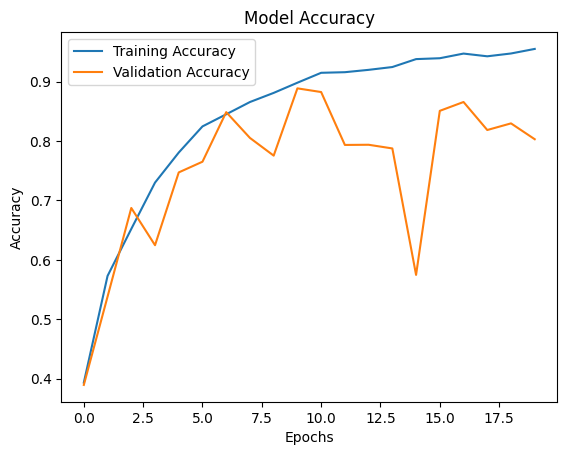

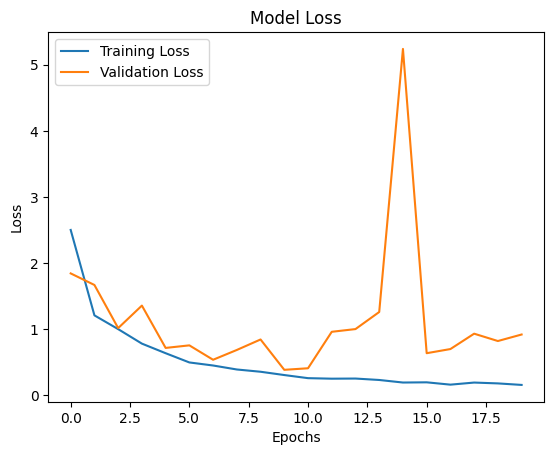

In [23]:
# Eğitim ve doğrulama doğruluğu
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Eğitim ve doğrulama kayıp değerleri
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


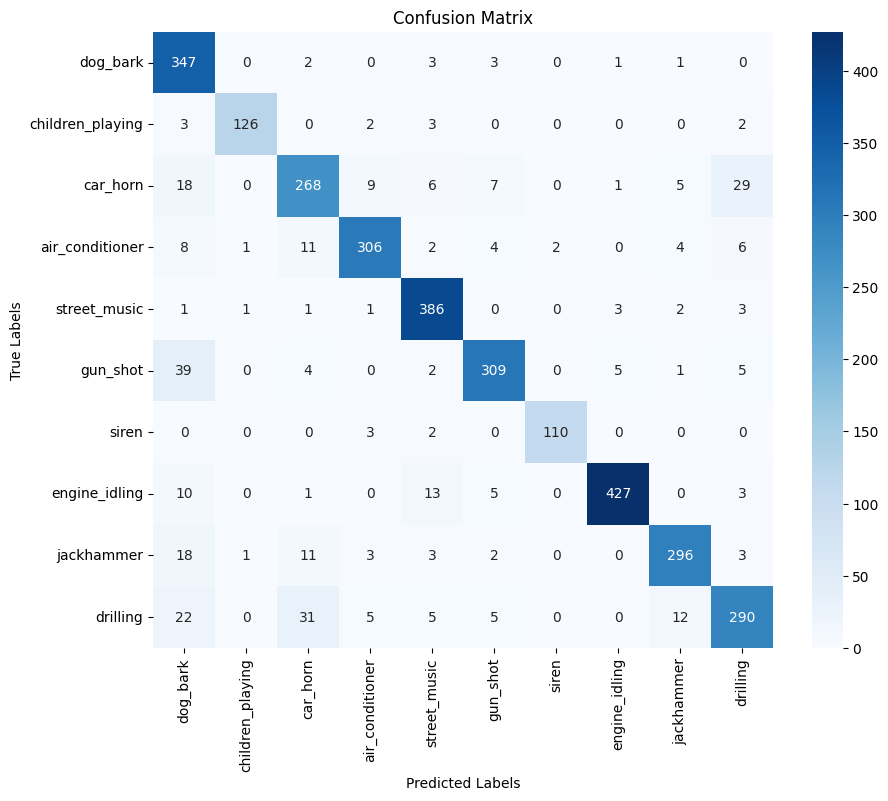

In [24]:
import seaborn as sns

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Actual Class: 3 - dog_bark
Predicted Class: 3 - dog_bark


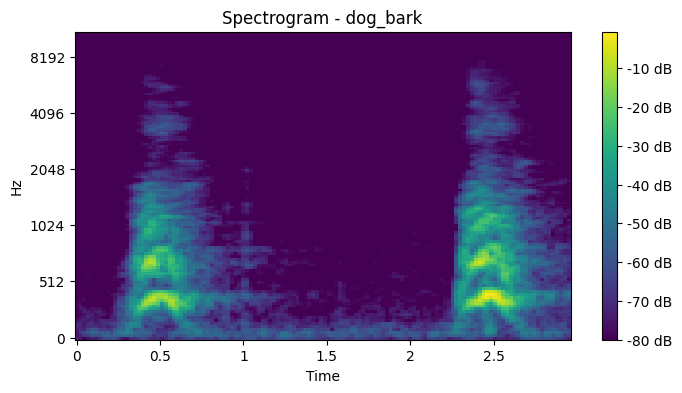

In [41]:
file_path = f"{audio_path}/fold1/101415-3-0-2.wav"
spectrogram = create_spectrogram(file_path)
actual_class_id = 3
actual_class_name = class_labels[actual_class_id]

if spectrogram is not None:
    # CNN giriş formatı için boyut ekleme
    spectrogram_for_model = spectrogram[np.newaxis, ..., np.newaxis]

    prediction = model.predict(spectrogram_for_model)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_id]

    print(f"Actual Class: {actual_class_id} - {actual_class_name}")
    print(f"Predicted Class: {predicted_class_id} - {predicted_class_name}")

    visualize_spectrogram(spectrogram, title=f"Spectrogram - {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Actual Class: 6 - gun_shot
Predicted Class: 6 - gun_shot


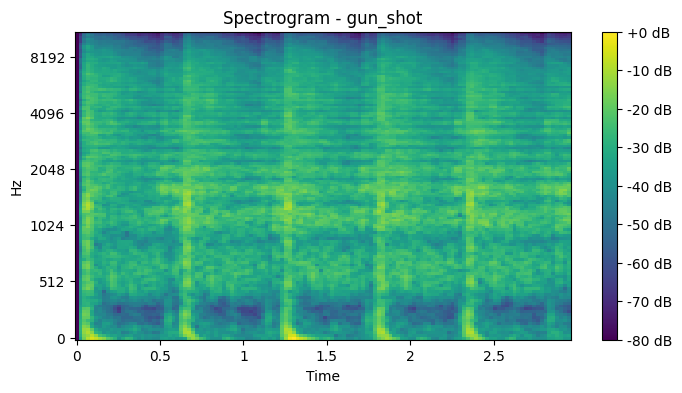

In [42]:
file_path = f"{audio_path}/fold1/7061-6-0-0.wav"
spectrogram = create_spectrogram(file_path)
actual_class_id = 6
actual_class_name = class_labels[actual_class_id]

if spectrogram is not None:
    # CNN giriş formatı için boyut ekleme
    spectrogram_for_model = spectrogram[np.newaxis, ..., np.newaxis]

    prediction = model.predict(spectrogram_for_model)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_id]

    print(f"Actual Class: {actual_class_id} - {actual_class_name}")
    print(f"Predicted Class: {predicted_class_id} - {predicted_class_name}")

    visualize_spectrogram(spectrogram, title=f"Spectrogram - {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Actual Class: 4 - drilling
Predicted Class: 4 - drilling


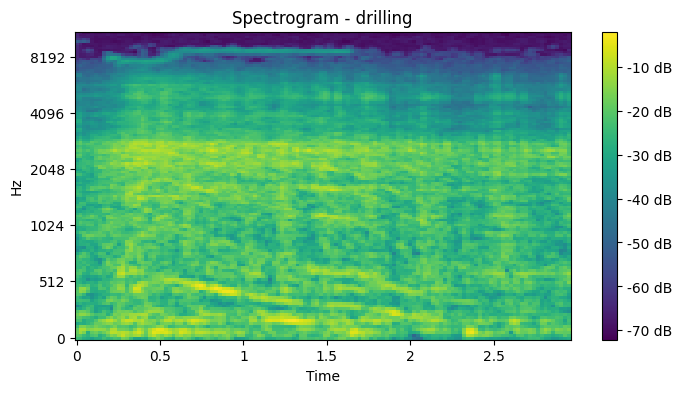

In [43]:
file_path = f"{audio_path}/fold1/14113-4-0-0.wav"
spectrogram = create_spectrogram(file_path)
actual_class_id = 4
actual_class_name = class_labels[actual_class_id]

if spectrogram is not None:
    # CNN giriş formatı için boyut ekleme
    spectrogram_for_model = spectrogram[np.newaxis, ..., np.newaxis]

    prediction = model.predict(spectrogram_for_model)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_id]

    print(f"Actual Class: {actual_class_id} - {actual_class_name}")
    print(f"Predicted Class: {predicted_class_id} - {predicted_class_name}")

    visualize_spectrogram(spectrogram, title=f"Spectrogram - {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Actual Class: 9 - street_music
Predicted Class: 9 - street_music


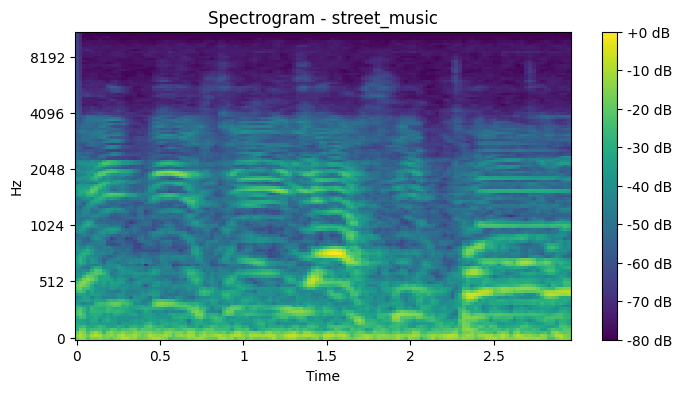

In [44]:
file_path = f"{audio_path}/fold2/14387-9-0-11.wav"
spectrogram = create_spectrogram(file_path)
actual_class_id = 9
actual_class_name = class_labels[actual_class_id]

if spectrogram is not None:
    # CNN giriş formatı için boyut ekleme
    spectrogram_for_model = spectrogram[np.newaxis, ..., np.newaxis]

    prediction = model.predict(spectrogram_for_model)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_id]

    print(f"Actual Class: {actual_class_id} - {actual_class_name}")
    print(f"Predicted Class: {predicted_class_id} - {predicted_class_name}")

    visualize_spectrogram(spectrogram, title=f"Spectrogram - {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Actual Class: 2 - children_playing
Predicted Class: 2 - children_playing


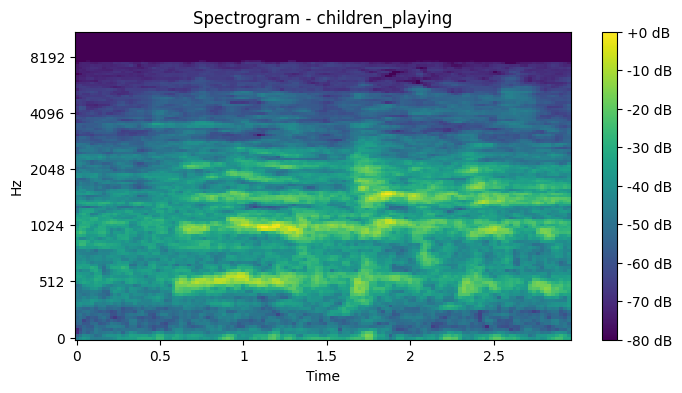

In [45]:
file_path = f"{audio_path}/fold1/97317-2-0-28.wav"
spectrogram = create_spectrogram(file_path)
actual_class_id = 2
actual_class_name = class_labels[actual_class_id]

if spectrogram is not None:
    # CNN giriş formatı için boyut ekleme
    spectrogram_for_model = spectrogram[np.newaxis, ..., np.newaxis]

    prediction = model.predict(spectrogram_for_model)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_id]

    print(f"Actual Class: {actual_class_id} - {actual_class_name}")
    print(f"Predicted Class: {predicted_class_id} - {predicted_class_name}")

    visualize_spectrogram(spectrogram, title=f"Spectrogram - {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Actual Class: 1 - car_horn
Predicted Class: 1 - car_horn


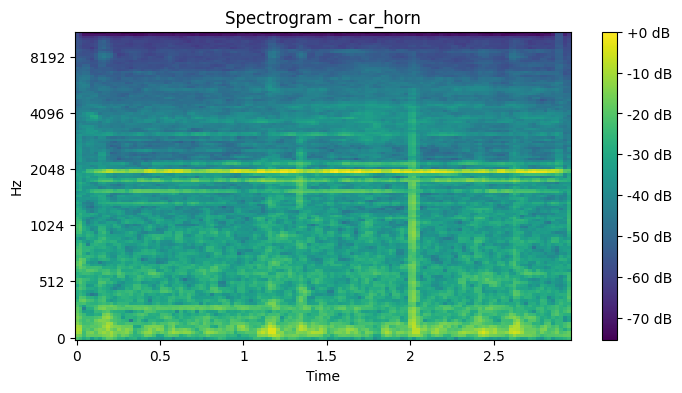

In [46]:
file_path = f"{audio_path}/fold2/132073-1-0-0.wav"
spectrogram = create_spectrogram(file_path)
actual_class_id = 1
actual_class_name = class_labels[actual_class_id]

if spectrogram is not None:
    # CNN giriş formatı için boyut ekleme
    spectrogram_for_model = spectrogram[np.newaxis, ..., np.newaxis]

    prediction = model.predict(spectrogram_for_model)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_id]

    print(f"Actual Class: {actual_class_id} - {actual_class_name}")
    print(f"Predicted Class: {predicted_class_id} - {predicted_class_name}")

    visualize_spectrogram(spectrogram, title=f"Spectrogram - {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Actual Class: 0 - air_conditioner
Predicted Class: 0 - air_conditioner


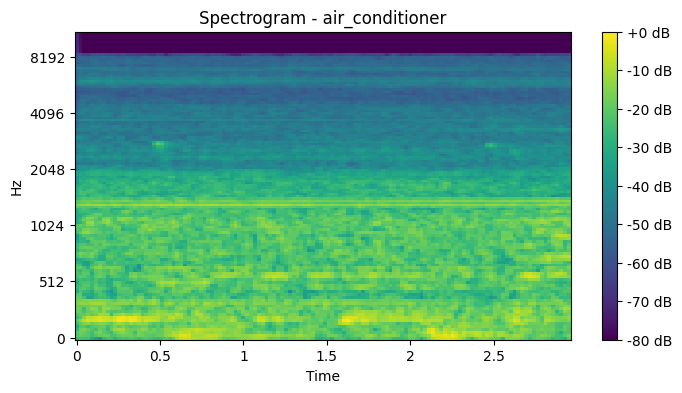

In [47]:
file_path = f"{audio_path}/fold3/13230-0-0-1.wav"
spectrogram = create_spectrogram(file_path)
actual_class_id = 0
actual_class_name = class_labels[actual_class_id]

if spectrogram is not None:
    # CNN giriş formatı için boyut ekleme
    spectrogram_for_model = spectrogram[np.newaxis, ..., np.newaxis]

    prediction = model.predict(spectrogram_for_model)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_id]

    print(f"Actual Class: {actual_class_id} - {actual_class_name}")
    print(f"Predicted Class: {predicted_class_id} - {predicted_class_name}")

    visualize_spectrogram(spectrogram, title=f"Spectrogram - {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Actual Class: 8 - siren
Predicted Class: 8 - siren


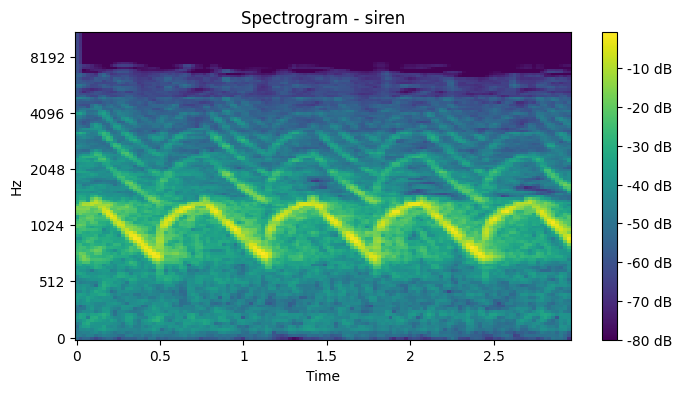

In [48]:
file_path = f"{audio_path}/fold3/184623-8-0-3.wav"
spectrogram = create_spectrogram(file_path)
actual_class_id = 8
actual_class_name = class_labels[actual_class_id]

if spectrogram is not None:
    # CNN giriş formatı için boyut ekleme
    spectrogram_for_model = spectrogram[np.newaxis, ..., np.newaxis]

    prediction = model.predict(spectrogram_for_model)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_id]

    print(f"Actual Class: {actual_class_id} - {actual_class_name}")
    print(f"Predicted Class: {predicted_class_id} - {predicted_class_name}")

    visualize_spectrogram(spectrogram, title=f"Spectrogram - {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Actual Class: 5 - engine_idling
Predicted Class: 5 - engine_idling


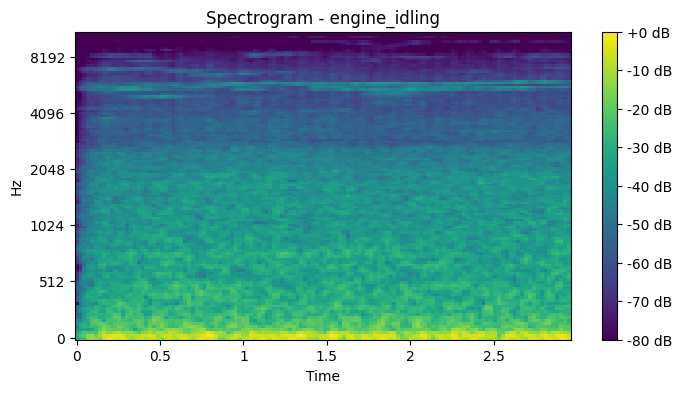

In [49]:
file_path = f"{audio_path}/fold2/201652-5-0-0.wav"
spectrogram = create_spectrogram(file_path)
actual_class_id = 5
actual_class_name = class_labels[actual_class_id]

if spectrogram is not None:
    # CNN giriş formatı için boyut ekleme
    spectrogram_for_model = spectrogram[np.newaxis, ..., np.newaxis]

    prediction = model.predict(spectrogram_for_model)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_id]

    print(f"Actual Class: {actual_class_id} - {actual_class_name}")
    print(f"Predicted Class: {predicted_class_id} - {predicted_class_name}")

    visualize_spectrogram(spectrogram, title=f"Spectrogram - {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Actual Class: 7 - jackhammer
Predicted Class: 7 - jackhammer


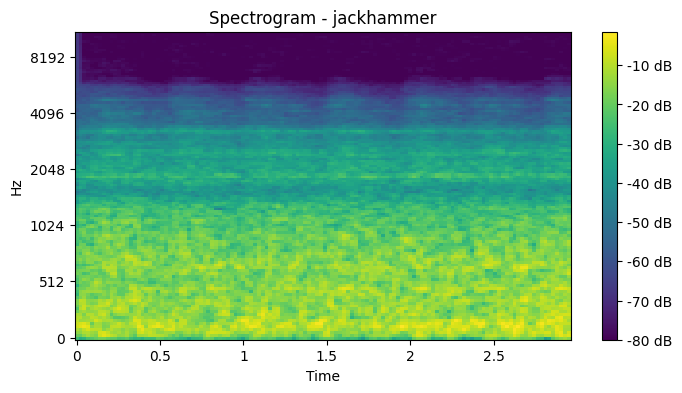

In [50]:
file_path = f"{audio_path}/fold2/203929-7-1-0.wav"
spectrogram = create_spectrogram(file_path)
actual_class_id = 7
actual_class_name = class_labels[actual_class_id]

if spectrogram is not None:
    # CNN giriş formatı için boyut ekleme
    spectrogram_for_model = spectrogram[np.newaxis, ..., np.newaxis]

    prediction = model.predict(spectrogram_for_model)
    predicted_class_id = np.argmax(prediction)
    predicted_class_name = class_labels[predicted_class_id]

    print(f"Actual Class: {actual_class_id} - {actual_class_name}")
    print(f"Predicted Class: {predicted_class_id} - {predicted_class_name}")

    visualize_spectrogram(spectrogram, title=f"Spectrogram - {predicted_class_name}")
